### Phase 4: Build LSTM model for forecast

In [1]:
# measure execution time
%load_ext autotime

time: 0 ns (started: 2023-06-30 14:30:19 +03:00)


In [2]:
# standard imports
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

time: 2.84 s (started: 2023-06-30 14:30:19 +03:00)


In [3]:
# Disable all warning messages
warnings.filterwarnings("ignore")

time: 0 ns (started: 2023-06-30 14:30:22 +03:00)


### Load the dataset

In [78]:
# read dataset
time_series = pd.read_csv('C:/Users/SK/Desktop/Diploma_Thesis/Datasets/San-Francisco-Yellow-Cabs/Files/time_series.txt')

# drop unecessary columns
time_series.drop(["Traj ID","Taxi ID"],axis=1,inplace=True)

# print first two rows
time_series.shape

(1000, 338)

time: 78 ms (started: 2023-06-30 14:39:11 +03:00)


### Preprocessing

In [79]:
# this list contains the column names
columns = ["Path","Length"]

# generate the columns of the dataset
i =2
while(True):
    if i == 2:
        columns.append(pd.to_datetime('2008-05-18 00:00:00'))
    else:
        columns.append(columns[i-1] + timedelta(seconds=1800))
    
    if (columns[i]>=pd.to_datetime('2008-05-24 23:59:59.000130')):
        break
    
    i+=1

# delete the last timestamp
columns.pop()

# assign new column names to our dataframe
time_series.columns = columns

# print first two rows
time_series.shape

(1000, 338)

time: 79 ms (started: 2023-06-30 14:39:11 +03:00)


#### Transform the dataset

In [80]:
data = pd.DataFrame(index=pd.to_datetime(time_series.iloc[:,2:].columns))

time: 0 ns (started: 2023-06-30 14:39:13 +03:00)


In [81]:
# reshape dataset
for i in range (time_series.shape[0]):
    data['Path_'+str(i)] = i
    data['Length_'+str(i)] = time_series.loc[i,'Length']
    data['Traffic_Flow_'+str(i)] = time_series.iloc[i,2:]

time: 3.55 s (started: 2023-06-30 14:39:14 +03:00)


In [82]:
# convert to integers
data = data.astype(int)

time: 171 ms (started: 2023-06-30 14:39:17 +03:00)


In [83]:
data.shape

(336, 3000)

time: 0 ns (started: 2023-06-30 14:39:17 +03:00)


#### Feature extraction from timestamps

In [84]:
# we define some features that might be usefull to our research
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['year'] = df.index.year
    df['day'] = data.index.day
    df['minute'] = data.index.minute
    return df

data = create_features(data)

time: 62 ms (started: 2023-06-30 14:39:20 +03:00)


In [85]:
# Circular Encoding for cyclic time features
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

time: 15 ms (started: 2023-06-30 14:39:21 +03:00)


In [86]:
data['weekend'] = (data['dayofweek'] >= 5).astype(int)
data['3_hour_interval'] = np.random.randint(1, 9, size=len(data))

time: 0 ns (started: 2023-06-30 14:39:59 +03:00)


In [87]:
data

,Path_0,Length_0,Traffic_Flow_0,Path_1,Length_1,Traffic_Flow_1,Path_2,Length_2,Traffic_Flow_2,Path_3,...,Traffic_Flow_999,hour,dayofweek,year,day,minute,hour_sin,hour_cos,weekend,3_hour_interval
2008-05-18 00:00:00,0,2,0,1,2,4,2,5,2,3,...,1,0,6,2008,18,0,0.000000,1.000000,1,7
2008-05-18 00:30:00,0,2,3,1,2,9,2,5,3,3,...,0,0,6,2008,18,30,0.000000,1.000000,1,4
2008-05-18 01:00:00,0,2,1,1,2,7,2,5,3,3,...,2,1,6,2008,18,0,0.258819,0.965926,1,5
2008-05-18 01:30:00,0,2,0,1,2,7,2,5,4,3,...,0,1,6,2008,18,30,0.258819,0.965926,1,5
2008-05-18 02:00:00,0,2,1,1,2,5,2,5,3,3,...,0,2,6,2008,18,0,0.500000,0.866025,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-05-24 21:30:00,0,2,1,1,2,6,2,5,2,3,...,0,21,5,2008,24,30,-0.707107,0.707107,1,2
2008-05-24 22:00:00,0,2,1,1,2,0,2,5,3,3,...,0,22,5,2008,24,0,-0.500000,0.866025,1,3
2008-05-24 22:30:00,0,2,0,1,2,4,2,5,1,3,...,0,22,5,2008,24,30,-0.500000,0.866025,1,4
2008-05-24 23:00:00,0,2,2,1,2,4,2,5,1,3,...,0,23,5,2008,24,0,-0.258819,0.965926,1,5


time: 31 ms (started: 2023-06-30 14:40:01 +03:00)


In [157]:
data = data[['Traffic_Flow_178','3_hour_interval','weekend','hour_sin','hour_cos']]

# define train data
train = data.loc[data.index < '2008-05-24']

# define test data
test = data.loc[data.index >= '2008-05-24']

print("Train set shape: ",train.shape)
print("Test set shape: ",test.shape)

KeyError: "['hour_sin', 'hour_cos'] not in index"

time: 2.45 s (started: 2023-06-30 14:45:24 +03:00)


In [ ]:
data

#### Scaling

In [ ]:
# print dtypes
data.dtypes

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Select only columns that denote traffic flow
#traffic_flow_columns = data.filter(like='Traffic_Flow_')
#traffic_flow_columns = data[['Traffic_Flow_1','hour','dayofweek','minute','day','hour_sin','hour_cos']]

# select only columns that denote time
#time = data[['hour','dayofweek','minute','day','hour_sin','hour_cos']]

#features = pd.concat([traffic_flow_columns, time], axis=1)

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Apply min-max scaling to the traffic flow  and time columns
X = scaler.fit_transform(train)
y = scaler.fit_transform(test)

In [ ]:
trainX = []
trainY = []
n_future = 1
n_past = 4

for i in range(n_past, len(X) - n_future +1):
    trainX.append(X[i-n_past:i, 0:X.shape[1]])
    trainY.append(X[i+n_future-1:i+n_future,0])
    
trainX, trainY = np.array(trainX), np.array(trainY)



In [ ]:
testX = []
testY = []
n_future = 1
n_past = 4

for i in range(n_past, len(y) - n_future +1):
    testX.append(y[i-n_past:i, 0:y.shape[1]])
    testY.append(y[i+n_future-1:i+n_future,0])
    
testX, testY = np.array(testX), np.array(testY)

#### Split the traffic flow information of each path to pairs (X,y)

In [ ]:
from numpy import array
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        
        X.append(seq_x)
        y.append(seq_y)
        
    return array(X), array(y)

In [ ]:
# choose a number of time steps
#n_steps_in, n_steps_out = 8, 2

# covert into input/output
#X, y = split_sequences(features, n_steps_in)

In [ ]:
# summarize the data
for i in range(len(X)):
    print(X[i], y[i])

#### Train - Test split

In [ ]:
#from sklearn.model_selection import train_test_split

In [ ]:
# Split into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [158]:
#X_train.shape, y_train.shape, X_test.shape, y_test.shape

time: 0 ns (started: 2023-06-30 14:45:27 +03:00)


### Define an LSTM model for forecast

In [159]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import tensorflow as tf

time: 0 ns (started: 2023-06-30 14:45:28 +03:00)


#### Create and compile the model

In [152]:
# the model knows the number of features
#n_features = X_train.shape[2]

time: 0 ns (started: 2023-06-30 14:44:42 +03:00)


In [167]:
# Define model
model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))  # Add dropout to the first LSTM layer
model.add(LSTM(150, activation='relu'))
model.add(Dropout(0.2))  # Add dropout to the second LSTM layer
model.add(Dense(trainY.shape[1]))

# Add early stopping
early_stopping = EarlyStopping(patience=50, monitor='val_loss', restore_best_weights=True)

time: 312 ms (started: 2023-06-30 15:18:06 +03:00)


In [168]:
# compile model
model.compile(optimizer='adam', loss='mse')

time: 16 ms (started: 2023-06-30 15:18:07 +03:00)


In [169]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((284, 4, 3), (284, 1), (44, 4, 3), (44, 1))

time: 16 ms (started: 2023-06-30 15:18:07 +03:00)


#### Train the model

In [170]:
# fit model on training data
model.fit(trainX, trainY, epochs=400, validation_data=(testX,testY), verbose=1, callbacks=[early_stopping])

Epoch 1/400
9/9 [==============================] - 4s 104ms/step - loss: 0.0631 - val_loss: 0.0512
Epoch 2/400
9/9 [==============================] - 0s 48ms/step - loss: 0.0416 - val_loss: 0.0492
Epoch 3/400
9/9 [==============================] - 0s 50ms/step - loss: 0.0345 - val_loss: 0.0417
Epoch 4/400
9/9 [==============================] - 0s 46ms/step - loss: 0.0323 - val_loss: 0.0418
Epoch 5/400
9/9 [==============================] - 0s 50ms/step - loss: 0.0321 - val_loss: 0.0426
Epoch 6/400
9/9 [==============================] - 0s 49ms/step - loss: 0.0313 - val_loss: 0.0409
Epoch 7/400
9/9 [==============================] - 0s 53ms/step - loss: 0.0296 - val_loss: 0.0406
Epoch 8/400
9/9 [==============================] - 1s 59ms/step - loss: 0.0295 - val_loss: 0.0383
Epoch 9/400
9/9 [==============================] - 0s 55ms/step - loss: 0.0289 - val_loss: 0.0387
Epoch 10/400
9/9 [==============================] - 0s 50ms/step - loss: 0.0279 - val_loss: 0.0367
Epoch 11/400
9/9 [

Epoch 84/400
9/9 [==============================] - 1s 59ms/step - loss: 0.0113 - val_loss: 0.0279
Epoch 85/400
9/9 [==============================] - 1s 71ms/step - loss: 0.0109 - val_loss: 0.0282
Epoch 86/400
9/9 [==============================] - 1s 75ms/step - loss: 0.0123 - val_loss: 0.0289
Epoch 87/400
9/9 [==============================] - 1s 69ms/step - loss: 0.0109 - val_loss: 0.0292
Epoch 88/400
9/9 [==============================] - 1s 69ms/step - loss: 0.0118 - val_loss: 0.0281
Epoch 89/400
9/9 [==============================] - 1s 59ms/step - loss: 0.0112 - val_loss: 0.0280


time: 45.6 s (started: 2023-06-30 15:18:08 +03:00)


In [160]:
# evaluate model on test data
loss = model.evaluate(testX, testY)
print("Test Loss:", loss)

2/2 [==============================] - 0s 10ms/step - loss: 0.0229
Test Loss: 0.02287701889872551
time: 125 ms (started: 2023-06-30 14:45:35 +03:00)


#### Predictions

In [161]:
# predict on test data
predictions = model.predict(testX)

2/2 [==============================] - 0s 8ms/step
time: 468 ms (started: 2023-06-30 14:45:36 +03:00)


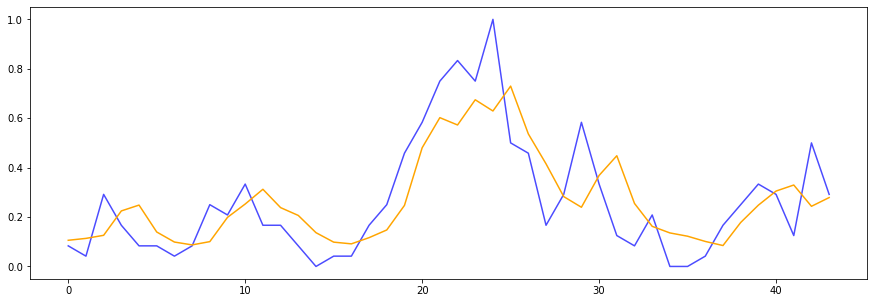

time: 234 ms (started: 2023-06-30 14:45:36 +03:00)


In [162]:
plt.figure(figsize=(15,5))
plt.plot(testY, color='blue', alpha=0.7, label='Actual')
plt.plot(predictions, color='orange', alpha=1, label='Predicted')